---
# 3 Regression Trees (LEAFToolbox - SL2P + ALR)

This notebook contains code blocks to generate predictions based on three different treatment methods, which are as follows:
1. SL2P10 – using only the output from SL2P10_10m
2. LARS + Regression Tree – using feature selection (LARS) and smileCART (GEE function)
3. LARS + Neural Network – as implemented by Hemit in ALR_client_side
---

In [1]:
import ee
service_account = '171083136856-compute@developer.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, 'privatekey.json')
ee.Initialize(credentials)

In [2]:
# import ee
import time
import math
import csv
import json
import os
import numpy as np
import pandas as pd
import folium  
from folium import plugins
import matplotlib.pyplot as plt
import scipy ; from scipy import stats
import scipy.io as sio
import sklearn as skl ; from sklearn import linear_model ; from sklearn import preprocessing
import tensorflow as tf
import pickle
from collections import OrderedDict
from PIL import Image

# import custom modules (files must be in same directory as this notebook)
import feature_collections as fc
import image_bands as ib
import wrapper_nets as wn
import ee_functions as ee_func
import ALR_functions as alr

In [3]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.7.0
Num GPUs Available:  1


2022-02-09 16:51:48.288946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-09 16:51:48.386367: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-09 16:51:48.386932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
### for accessing earth engine asset
ee.Initialize()
ee.Authenticate()

Enter verification code:  4/1AX4XfWi1Kb6D78EbalOBn-I0yyK_qv3LBncUlW33L1F3XtNXtz3EhyOe1RE



Successfully saved authorization token.


---
# Prelim: Define dictionaries

In [5]:
# -----------------------
# SELECT INPUT PARAMETERS
# -----------------------

# variable name
# one of: 'fAPAR', 'fCOVER', 'LAI'
#outputName = 'LAI'
outputName = 'LAI'

# site selection
# one of: 'Geraldton', 'FoxCreek', 'Kouchibouguac', 'Ottawa',
#         'Wabush', 'QueenCharlotte', 'Attawapiskat', 'Eastmain', 'Charlottetown', 'RedBay', 'EaglePlain', 'Kitchener'
#siteSelect = 'Charlottetown'
siteSelect = 'Charlottetown'
assetfolder='users/ganghong/ALR'

In [6]:
# -----------------------------------------------------
# set parameters based on user-defined parameters above
# -----------------------------------------------------
outputParams = {
    'fAPAR': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 1
    },
    'fCOVER': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 1
    },
    'LAI': {
        'outputScale': 1000,
        'outputOffset': 0,
        'outputMax': 8
    }
}

outputScale = outputParams[outputName]['outputScale']
outputOffset = outputParams[outputName]['outputOffset']
outputMax = outputParams[outputName]['outputMax']
responseBand = 'estimate'+outputName

In [7]:
siteParams = {
    # Geraldton, ON
    'Geraldton': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200811T164849_20200811T165525_T16UEA'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-86, 49.5], \
                          [-86, 50], \
                          [-85.5, 50], \
                          [-85.5, 49.5]]]),
        'mapCenter': [-85.75, 49.75]
    },
    # Fox Creek, AB
    'FoxCreek': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20210825T185919_20210825T190431_T11UNA'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-117, 54], \
                          [-117, 55], \
                          [-115, 55], \
                          [-115, 54]]]),
        'mapCenter': [-116.8, 54.4]
    },
    # Kouchibouguac, NB
    'Kouchibouguac': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200905T151701_20200905T151829_T20TLS'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-65, 46], \
                          [-65, 47], \
                          [-64, 47], \
                          [-64, 46]]]),
        'mapCenter': [-64.5, 46.5]
    },
    # Ottawa, ON
    'Ottawa': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200801T155911_20200801T160644_T18TVQ'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-75, 45], \
                          [-75, 46], \
                          [-74, 46], \
                          [-74, 45]]]),
        'mapCenter': [-74.5, 45.5]
    },
    # Wabush, NL
    'Wabush': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200815T153911_20200815T154107_T19UFU'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-67.5, 52.3], \
                          [-67.5, 53.2], \
                          [-66.3, 53.2], \
                          [-66.3, 52.3]]]),
        'mapCenter': [-67, 52.8]
    },
    # Queen Charlotte Island, BC
    'QueenCharlotte': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200909T194951_20200909T195633_T08UPE'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-133, 53.2], \
                          [-133, 54], \
                          [-132, 54], \
                          [-132, 53.2]]]),
        'mapCenter': [-132.4, 53.6]
    },
    # Attawapiskat, ON
    'Attawapiskat': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200815T162839_20200815T163731_T17ULU'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-83, 52.3], \
                          [-83, 53.2], \
                          [-82.4, 53.2], \
                          [-82.4, 52.3]]]),
        'mapCenter': [-82.7, 52.7]
    },
    # Eastmain, QC
    'Eastmain': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200723T161829_20200723T162656_T17UPT'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-79.5, 51.4], \
                          [-79.5, 52.3], \
                          [-78, 52.3], \
                          [-78, 51.4]]]),
        'mapCenter': [-78.7, 51.8]
    },
    # Charlottetown, PEI
    'Charlottetown': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200622T151659_20200622T151653_T20TMS'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-63.3, 46.1], \
                          [-63.3, 46.5], \
                          [-62.9, 46.5], \
                          [-62.9, 46.1]]]),
        'mapCenter': [-63.1, 46.3]
    },
    # Red Bay, NL
    'RedBay': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200716T145729_20200716T145730_T21UWT'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-56.6, 51.6], \
                          [-56.6, 52.3], \
                          [-55.6, 52.3], \
                          [-56.6, 51.6]]]),
        'mapCenter': [-56, 52]
    },
    # Eagle Plain, YT
    'EaglePlain': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200731T204019_20200731T204021_T08WMU'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-137, 65.75], \
                          [-137, 66.5], \
                          [-135, 66.5], \
                          [-135, 65.75]]]),
        'mapCenter': [-136.3, 66.5]
    },
    # Kitchener, ON
    'Kitchener': {
        'testImage': ee.Image('COPERNICUS/S2_SR/20200615T160911_20200615T161838_T17TNJ'),
        'mapBounds': ee.Geometry.Polygon( \
                        [[[-81, 43.3], \
                          [-81, 44], \
                          [-79.8, 44], \
                          [-79.8, 43.3]]]),
        'mapCenter': [-80.5, 43.7]
    }
}

mapBounds = siteParams[siteSelect]['mapBounds']
mapCenter = siteParams[siteSelect]['mapCenter']
testImage = siteParams[siteSelect]['testImage']

# other filters
maxCloudcover = 10

# export parameters
exportFolder = siteSelect+'_'+outputName
exportDataType = 'int'
exportScale = 20

In [8]:
COLLECTION_OPTIONS = {
    # Sentinel 2 using 20 m bands:
    'COPERNICUS/S2_SR': {
      "name": 'COPERNICUS/S2_SR',
      "description": 'Sentinel 2A',
      "Cloudcover": 'CLOUDY_PIXEL_PERCENTAGE',
      "Watercover": 'WATER_PERCENTAGE',
      "sza": 'MEAN_SOLAR_ZENITH_ANGLE',
      "vza": 'MEAN_INCIDENCE_ZENITH_ANGLE_B8A',
      "saa": 'MEAN_SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(fc.s2_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(fc.s2_createFeatureCollection_errors()),  
      "sl2pDomain": ee.FeatureCollection(fc.s2_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(fc.s2_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(fc.s2_createImageCollection_partition()),
      "legend": ee.FeatureCollection(fc.s2_createFeatureCollection_legend()),
      "numVariables": 7
    },
    # Sentinel 2 using 10 m bands:
    'COPERNICUS/S2_SR_10m': {
      "name": 'COPERNICUS/S2_SR',
      "description": 'Sentinel 2A',
      "Cloudcover": 'CLOUDY_PIXEL_PERCENTAGE',
      "Watercover": 'WATER_PERCENTAGE',
      "sza": 'MEAN_SOLAR_ZENITH_ANGLE',
      "vza": 'MEAN_INCIDENCE_ZENITH_ANGLE_B8A',
      "saa": 'MEAN_SOLAR_AZIMUTH_ANGLE', 
      "vaa": 'MEAN_INCIDENCE_AZIMUTH_ANGLE_B8A',
      "VIS_OPTIONS": 'VIS_OPTIONS',
      "Collection_SL2P": ee.FeatureCollection(fc.s2_10m_createFeatureCollection_estimates()),
      "Collection_SL2Perrors": ee.FeatureCollection(fc.s2_10m_createFeatureCollection_errors()),  
      "sl2pDomain": ee.FeatureCollection(fc.s2_10m_createFeatureCollection_domains()),
      "Network_Ind": ee.FeatureCollection(fc.s2_createFeatureCollection_Network_Ind()),
      "partition": ee.ImageCollection(fc.s2_createImageCollection_partition()),
      "legend": ee.FeatureCollection(fc.s2_createFeatureCollection_legend()),
      "numVariables": 7
    }
}

VIS_OPTIONS = {
    'fAPAR': {
        "COPERNICUS/S2_SR": {
            "Name": 'fAPAR',
            "errorName": 'errorfAPAR',
            "maskName": 'maskfAPAR',
            "description": 'Fraction of absorbed photosynthetically active radiation',
            "variable": 2,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'fAPAR',
            "errorName": 'errorfAPAR',
            "maskName": 'maskfAPAR',
            "description": 'Fraction of absorbed photosynthetically active radiation',
            "variable": 2,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    },
    'fCOVER': {
        "COPERNICUS/S2_SR": {
            "Name": 'fCOVER',
            "errorName": 'errorfCOVER',
            "maskName": 'maskfCOVER',
            "description": 'Fraction of canopy cover',
            "variable": 3,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]]))) 
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'fCOVER',
            "errorName": 'errorfCOVER',
            "maskName": 'maskfCOVER',
            "description": 'Fraction of canopy cover',
            "variable": 3,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]]))) 
        }
    },
    'LAI': {
        "COPERNICUS/S2_SR": {
            "Name": 'LAI',
            "errorName": 'errorLAI',
            "maskName": 'maskLAI',
            "description": 'Leaf area index',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        },
        "COPERNICUS/S2_SR_10m": {
            "Name": 'LAI',
            "errorName": 'errorLAI',
            "maskName": 'maskLAI',
            "description": 'Leaf area index',
            "variable": 1,
            "inputBands":      ['cosVZA', 'cosSZA', 'cosRAA', 'B2', 'B3', 'B4', 'B8'],
            "inputScaling":    [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001],
            "outmin": (ee.Image(ee.Array([[0]]))),
            "outmax": (ee.Image(ee.Array([[1]])))
        }
    }
}

---
# 1 – SL2P/SL2P10

### SL2P Original (create image and export to EE)

In [9]:
# parse the networks
colName = 'COPERNICUS/S2_SR'
colOptions = COLLECTION_OPTIONS[colName]
netOptions = VIS_OPTIONS[outputName][colName]
numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));

In [10]:
# filter collection and add ancillary bands

input_collection = ee.ImageCollection(testImage) \
                     .map(lambda image: ib.addDate(image)) \
                     .map(lambda image: image.clip(mapBounds)) \
                     .map(lambda image: ib.s2MaskClear(image)) \
                     .map(lambda image: ib.s2MaskLand(image)) \
                     .map(lambda image: ib.addS2Geometry(colOptions, image))

# get partition used to select network
partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition')

# pre process input imagery and flag invalid inputs
scaled_input_collection = input_collection.map(lambda image: ib.scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                          .map(lambda image: ib.invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))

# apply networks to produce mapped parameters
estimateSL2P = scaled_input_collection.map(lambda image: wn.wrapperNNets(SL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "estimate", image, outputName))
uncertaintySL2P = scaled_input_collection.map(lambda image: wn.wrapperNNets(errorsSL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "error", image, outputName))

# scale and offset mapped parameter bands
estimateSL2P = estimateSL2P.map(lambda image: image.addBands(image.select("estimate"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)), overwrite=True))
uncertaintySL2P = uncertaintySL2P.map(lambda image: image.addBands(image.select("error"+outputName).multiply(ee.Image.constant(outputScale)).add(ee.Image.constant(outputOffset)), overwrite=True))

# produce final export collection
export_collection = input_collection.combine(estimateSL2P).combine(uncertaintySL2P)
    
image_output_names = ([name +"_"+siteSelect +"_"+outputName for name in export_collection.toList(export_collection.size()).map(lambda image: ee.Image(image).id()).getInfo()])
ee_func.displayImage(export_collection.mosaic().select('estimate'+outputName),0+outputOffset,10*outputScale+outputOffset, mapBounds)

In [23]:
# export tasks to Earth Engine
export_task = ee_func.export_collection_to_gee(collection=export_collection,
                                               num_images=1,
                                               # image_names=[siteSelect+'_'+outputName+'_SL2P'],
                                               image_names = image_output_names,
                                               scale=10,
                                               # asset_folder='users/kateharvey/SL2P_images',
                                               asset_folder=assetfolder,
                                               data_type=exportDataType,
                                               max_pixels=1e13)

### SL2P10 (for comparison)

In [11]:
# parse the networks
colName = 'COPERNICUS/S2_SR_10m'
colOptions = COLLECTION_OPTIONS[colName]
netOptions = VIS_OPTIONS[outputName][colName]
numNets = ee.Number(ee.Feature((COLLECTION_OPTIONS[colName]["Network_Ind"]).first()).propertyNames().remove('Feature Index').remove('system:index').remove('lon').size())
SL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2P"],numNets,netNum));
errorsSL2P = ee.List.sequence(1,ee.Number(COLLECTION_OPTIONS[colName]["numVariables"]),1).map(lambda netNum: wn.makeNetVars(COLLECTION_OPTIONS[colName]["Collection_SL2Perrors"],numNets,netNum));

In [12]:
# performs same procedure as above, using SL2P10 network
# applies algorithm to 10 m bands ; generates a 10 m map

# filter collection and add ancillary bands
input_collection_10m = ee.ImageCollection(testImage) \
                     .map(lambda image: ib.addDate(image)) \
                     .map(lambda image: image.clip(mapBounds)) \
                     .map(lambda image: ib.s2MaskClear(image)) \
                     .map(lambda image: ib.s2MaskLand(image)) \
                     .map(lambda image: ib.addS2Geometry(colOptions, image))

# get partition used to select network
partition = (COLLECTION_OPTIONS[colName]["partition"]).filterBounds(mapBounds).mosaic().clip(mapBounds).rename('partition')

# pre process input imagery and flag invalid inputs
scaled_input_collection_10m = input_collection_10m.map(lambda image: ib.s2MaskLand(image)) \
                                                  .map(lambda image: ib.scaleBands(netOptions["inputBands"],netOptions["inputScaling"],image)) \
                                                  .map(lambda image: ib.invalidInput(COLLECTION_OPTIONS[colName]["sl2pDomain"],netOptions["inputBands"],image))

# apply networks to produce mapped parameters
estimateSL2P_10m = scaled_input_collection_10m.map(lambda image: wn.wrapperNNets(SL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "estimate", image, outputName))
uncertaintySL2P_10m = scaled_input_collection_10m.map(lambda image: wn.wrapperNNets(errorsSL2P, partition, netOptions, COLLECTION_OPTIONS[colName], "error", image, outputName))

# scale and offset mapped parameter bands
estimateSL2P_10m = estimateSL2P_10m.map(lambda image: image.addBands(image.select("estimate"+outputName) \
                                                             .multiply(ee.Image.constant(outputScale)) \
                                                             .add(ee.Image.constant(outputOffset)), overwrite=True))
uncertaintySL2P_10m = uncertaintySL2P_10m.map(lambda image: image.addBands(image.select("error"+outputName) \
                                                                   .multiply(ee.Image.constant(outputScale)) \
                                                                   .add(ee.Image.constant(outputOffset)), overwrite=True))


# produce final export collection
export_collection_10m = input_collection_10m.combine(estimateSL2P_10m).combine(uncertaintySL2P_10m)

image_output_names_10m = ([name+"_"+siteSelect+"_"+outputName+"_10m" for name in export_collection_10m.toList(export_collection_10m.size()).map(lambda image: ee.Image(image).id()).getInfo()])

ee_func.displayImage(export_collection_10m.mosaic().select('estimate'+outputName),0+outputOffset,10*outputScale+outputOffset, mapBounds)

In [ ]:
# export tasks to Earth Engine
export_task_10m = ee_func.export_collection_to_gee(collection=export_collection_10m,
                                                   num_images=1,
                                                   # image_names=[siteSelect+'_'+outputName+'_SL2P10'],
                                                   image_names = image_output_names_10m,
                                                   scale=10,
                                                   # asset_folder='users/kateharvey/SL2P10_images',
                                                   asset_folder=assetfolder,
                                                   data_type=exportDataType,
                                                   max_pixels=1e13)

# 2 – Active Learning Regularization (LARS Feature Selection)

Note: the responseBand from the above step doesn't have a geometry associated with it (only happens after being uploaded to GEE) so the image will have to be defined from existing GEE asset for the remaining steps even though the same image was created as inputImage (should be identical except for geometry)

In [11]:
# order of bands from SL2P output:
# 00-11: 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 
# 12-19: 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 
# 20-26: 'QA10', 'QA20', 'QA60', 'date', 'cosVZA', 'cosSZA', 'cosRAA', 
# 27-32: 'estimateLAI', 'partition', 'networkID', 'errorLAI', 'partition_1', 'networkID_1'

# define 10m band input image ; name bands of inputImage and scale response band
# inputImage = ee.Image('users/ganghong/ALR/'+siteSelect+'_'+outputName+'_SL2P').select(1,2,3,7,22,23,27,28,29,30,31,32)
inputImage = ee.Image(assetfolder+'/'+image_output_names[0]).select(1,2,3,7,22,23,27,28,29,30,31,32)
inputImage_bands = ee.List(['B2', 'B3', 'B4', 'B8', 'QA60', 'date', 'estimate'+outputName, 'partition', 'networkID', 'error'+outputName, 'partition_1', 'networkID_1'])
inputImage = inputImage.rename(inputImage_bands)
# print (inputImage.getInfo())

In [12]:
# Only include VIs that use B2, B3, B4, B8 to create a 10 m product
input_VI_definition = ee.List([# "RAW_B2  = b('B2')",
                             # "RAW_B3  = b('B3')",
                             # "RAW_B4  = b('B4')",
                             # "RAW_B8  = b('B8')",
                               "GI      = b('B3')/b('B4')",
                             # "RVI3    = b('B4')/b('B6')",
                             # "SR3     = b('B5')/b('B4')",
                             # "GM1     = b('B6')/b('B3')",
                             # "GM2     = b('B6')/b('B5')",
                             # "SR2     = b('B7')/b('B3')",
                             # "PSSR    = b('B7')/b('B4')",
                               "SGI     = b('B8')/b('B4')",
                             # "MSI     = b('B11')/b('B7')",
                             # "II      = b('B11')/b('B12')",
                               "GVI     = (b('B8')/b('B3'))-1",
                             # "PSRI    = (b('B4')-b('B3'))/b('B6')",
                               "NDVI3   = ((b('B8')-b('B4'))/(b('B8')))+b('B4')",
                             # "SR5     = 1/b('B5')",
                             # "SR6     = b('B4')/(b('B3')*b('B5'))",
                             # "SR7     = b('B8')/(b('B3')*b('B5'))",
                             # "IPVI    = b('B7')/(b('B7')+b('B4'))",
                             # "ARI     = (1/b('B3'))-(1/b('B5'))",
                             # "ARI2    = b('B7')*((1/b('B3'))-(1/b('B5')))",
                               "NDVI    = (b('B8')-b('B4'))/(b('B8')+b('B4'))",
                               "GNDVI   = (b('B8')-b('B3'))/(b('B8')+b('B3'))",
                             # "NDWI    = (b('B8')-b('B11'))/(b('B8')+b('B11'))",
                             # "NDREVI  = (b('B8')-b('B5'))/(b('B8')+b('B5'))",
                               "NDGI    = (b('B3')-b('B4'))/(b('B3')+b('B4'))",
                             # "NDI1    = (b('B7')-b('B5'))/(b('B7')-b('B4'))",
                             # "NDI2    = (b('B8')-b('B5'))/(b('B8')-b('B4'))",
                             # "RENDVI  = (b('B6')-b('B5'))/(b('B6')+b('B5'))",
                             # "OSAVI   = (1.16*(b('B7')-b('B4')))/(b('B7')+b('B4')+0.61)",
                             # "NMDI    = (b('B8')-(b('B11')-b('B12')))/(b('B8')+(b('B11')-b('B12')))",
                             # "HI      = ((b('B3')-b('B5'))/(b('B3')+b('B5')))-0.5*b('B5')",
                             # "GVSP    = (-0.283*b('B3') - 0.66*b('B4') + 0.577*b('B6') + 0.388*b('B8'))/(0.433*b('B3') - 0.632*b('B4') + 0.586*b('B6') + 0.264*b('B8A'))",
                             # "MCARI   = ((b('B5')-b('B4'))-0.2*(b('B5')-b('B3')))*(b('B5')/b('B4'))",
                             # "TCARI   = 3*((b('B5')-b('B4'))-0.2*(b('B5')-b('B3'))*(b('B5')/b('B4')))",
                               "EVI     = 2.5*((b('B8')-b('B4'))/(b('B8')+6*b('B4')-7.5*b('B3')+1))",
                               "EVI2    = 2.5*((b('B8')-b('B4'))/(b('B8')+2.4*b('B4')+1))",
                               "RDVI    = (b('B8')-b('B4'))/((b('B8')+b('B4'))**0.5)",
                               "MSR     = ((b('B8')/b('B4'))-1)/((b('B8')/b('B4'))**0.5+1)",
                             # "MSAVI   = 0.5*(2*b('B7')+1-((2*b('B7')+1)**2-8*(b('B7')-b('B4')))**0.5)",
                               "MSAVI2  = 0.5*(2*b('B8')+1-((2*b('B8')+1)**2-8*(b('B8')-b('B4')))**0.5)",
                             # "MCARI2  = (1.5*(2.5*(b('B7')-b('B4'))-1.3*(b('B7')-b('B3'))))/((((2*b('B7')+1)**2)-(6*b('B7')-5*(b('B4')**0.5))-0.5)**0.5)",
                             # "MTVI2   = (1.5*(1.2*(b('B7')-b('B3'))-2.5*(b('B4')-b('B3'))))/(((2*b('B7')+1)**2-(6*b('B7')-5*b('B4'))-0.5)**0.5)",
                             # "MSR2    = ((b('B7')/b('B4'))-1)/(((b('B7')/b('B4'))+1)**0.5)",
                               "NLI     = ((b('B8')**2)-b('B4'))/((b('B8')**2)+b('B4'))"])

# names of bands to pass to ALR method (excluding metadata and other non-spectral bands)
input_bandNames = ['B2', 'B3', 'B4', 'B8', 'GI', 'SGI', 'GVI', 'NDVI3', 'NDVI', 'GNDVI', 'NDGI', 'EVI', 'EVI2', 'RDVI', 'MSR', 'MSAVI2', 'NLI']

In [13]:
# format image and generate list of selected features
inputImage = alr.format_image(inputImage, inputImage_bands, responseBand, input_VI_definition)

In [14]:
# prepares the image to be ingested by the LARS algorithm
# returns an image with the response band centred to a mean 0, and the other bands in the image standardized
# to a mean 0 and standard deviation 1
scaledImage = alr.scale_image(inputImage, responseBand)

In [15]:
# apply ALR to the image and obtain the features selected for the model
# parameters: ee_LARS(inputImage, bandNames, responseBand, numFeatures, numSamples)
select_features = alr.ee_LARS(scaledImage, input_bandNames, responseBand, 5, 50000)

selected features:  ['GVI', 'RDVI', 'EVI2', 'MSR', 'NDGI']


### Export VI Image

In [31]:
# export formatted image to google drive (with added VI bands)
# this will be used in the next section to train the regression tree
export = ee.ImageCollection(inputImage)

export_task = ee_func.export_collection_to_gee(collection=export,
                                                 num_images=1,
                                                 # image_names=[siteSelect+'_'+outputName+'_VI'],
                                                 # asset_folder='users/kateharvey/vi_images',  # replace with EE destination folder                                                 
                                                 image_names=[siteSelect+'_'+outputName+'_VI'],
                                                 asset_folder=assetfolder,  # replace with EE destination folder
                                                 scale=10,
                                                 data_type=exportDataType,
                                                 max_pixels=1e13)

---
# 2a – Regression Tree (Random Forest and CART)

### Train and Apply Regression Tree to Image

In [20]:
# DEFINE IMAGE & FORMAT BANDS
# unclassified = ee.Image('users/kateharvey/vi_images/'+siteSelect+'_'+outputName+'_VI')
unclassified = ee.Image(assetfolder+'/'+siteSelect+'_'+outputName+'_VI')
bands = ee.List([responseBand, 'GI', 'SGI', 'GVI', 'NDVI3', 'NDVI', 'GNDVI', 'NDGI',
                 'EVI', 'EVI2', 'RDVI', 'MSR', 'MSAVI2', 'NLI', 'B2', 'B3', 'B4', 'B8',
                 'QA60', 'date', 'partition', 'networkID', 'error'+outputName, 'partition_1', 'networkID_1'])
unclassified = unclassified.rename(bands)

# prediction bands (equivalent to select_features, with responseBand)
bands = select_features
input_bands = select_features.add(responseBand)

In [21]:
# GET TRAINING DATASET
# Feature Vector (table) used to train regression model (select only prediction bands)
training_data = ee.FeatureCollection(unclassified.sample(numPixels=1000, seed=1).select(input_bands))

In [22]:
# CREATE CLASSIFIERS

# implement regression tree with Random Forest algorithm
# optional parameters for smileRandomForest(): variablesPerSplit, minLeafPopulation, bagFraction, maxNodes, seed
rf_classifier = ee.Classifier.smileRandomForest(100).setOutputMode('REGRESSION').train(features=training_data,
                                                                                       classProperty=responseBand,
                                                                                       inputProperties=input_bands)

# implement regression tree with CART (Classification and Regression Tree) algorithm
# optional parameters for smileCart(): maxNodes, minLeafPopulation
cart_classifier = ee.Classifier.smileCart().setOutputMode('REGRESSION').train(features=training_data,
                                                                              classProperty=responseBand,
                                                                              inputProperties=input_bands)

In [23]:
# CLASSIFY IMAGE
rf_classified = unclassified.select(bands).classify(rf_classifier, 'rf_'+responseBand).clip(mapBounds)
cart_classified = unclassified.select(bands).classify(cart_classifier, 'cart_'+responseBand).clip(mapBounds)

In [24]:
# CHECK RESULTS (CROSS-VALIDATION)
joined_image = unclassified.select(responseBand).addBands(rf_classified.select('rf_'+responseBand)).addBands(cart_classified.select('cart_'+responseBand))

# using same random seed as training_data, get 2000 samples and discard the first 1000, leaving 1000 different samples for cross-validation
# this sampling method ensures no overlap between training and testing datasets
joined_samples = ee.FeatureCollection(joined_image.sample(numPixels=2000, seed=1).toList(2000, 1000))

### Export Feature Collection (for scatter plot comparison in next section)

In [ ]:
# export_csv = ee.batch.Export.table.toDrive(collection=joined_samples,
#                                            description=siteSelect+'_'+outputName+'_regression_tree',
#                                            fileFormat='CSV')

# # Start the export task
# export_csv.start()

In [ ]:
# # Wait loop to see if the data has finished exporting by checking with the server-side
# prev_task_status = ee.data.getTaskStatus(export_csv.id)[0]["state"]
# print(prev_task_status)
# while export_csv.active():
#     task_status = ee.data.getTaskStatus(export_csv.id)[0]["state"]
#     if(task_status != prev_task_status):
#         print(task_status)
#     prev_task_status = task_status
#     time.sleep(5)
# print(ee.data.getTaskStatus(export_csv.id)[0]["state"])

In [24]:
csv_task = ee.batch.Export.table.toCloudStorage(
    collection=joined_samples, 
    description=siteSelect+'_'+outputName+'_regression_tree', 
    bucket='eealr',     
    fileFormat='CSV')

In [25]:
csv_task.start()

### Visualize and Compare Predictions:

In [25]:
# Read the CSV file into dataframe
# data = pd.read_csv('./gdrive/'+siteSelect+'_'+outputName+'_regression_tree.csv')
data = pd.read_csv('gs://eealr/'+siteSelect+'_'+outputName+'_regression_tree.csv')

# remove rows that have a value of 0 for the responseBand
data = data[data[responseBand] != 0]


# Get column data (for plots [0,1] and [1,1])
rf = data['rf_'+responseBand]/1000    # divide by 1000 to get properly scaled values for the variable
cart = data['cart_'+responseBand]/1000
actual = data[responseBand]/1000

# Obtain point density to display as a scatterplot (KDE)
xy_rf = np.vstack([actual, rf])
z_rf = scipy.stats.gaussian_kde(xy_rf)(xy_rf)

xy_cart = np.vstack([actual, cart])
z_cart = scipy.stats.gaussian_kde(xy_cart)(xy_cart)


# Sort by responseBand in ascending order (for plots [0,0] and [1,0] below)
data_sorted = data.sort_values(responseBand, axis=0).reset_index(drop=True)
rf_sorted = data_sorted['rf_'+responseBand]/1000
cart_sorted = data_sorted['cart_'+responseBand]/1000
actual_sorted = data_sorted[responseBand]/1000
index_sorted = data_sorted.index

# Obtain point density for sorted values
xy_rf_sorted = np.vstack([actual_sorted, rf_sorted])
z_rf_sorted = scipy.stats.gaussian_kde(xy_rf_sorted)(xy_rf_sorted)

xy_cart_sorted = np.vstack([actual_sorted, cart_sorted])
z_cart_sorted = scipy.stats.gaussian_kde(xy_cart_sorted)(xy_cart_sorted)

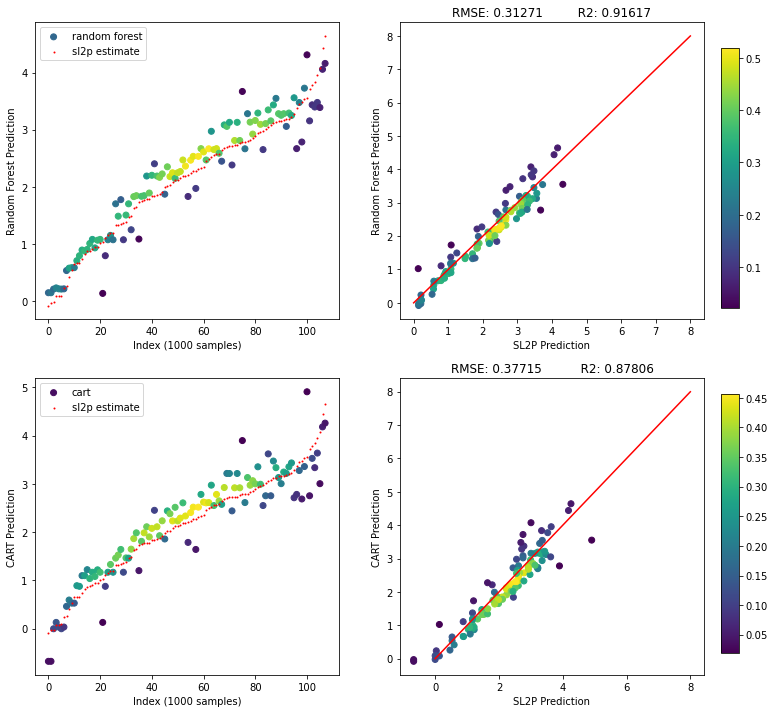

In [26]:
# PLOT & COMPARE PREDICTIONS FROM BOTH REGRESSION TREES
fig, ax = plt.subplots(2, 2, figsize=(12,12))
xy = np.linspace(0, outputMax, 100)

# ax[0,0]
fig1 = ax[0,0].scatter(index_sorted, rf_sorted, c=z_rf_sorted, label='random forest')
ax[0,0].scatter(index_sorted, actual_sorted, c='r', s=1, label='sl2p estimate')
rf_rmse_sorted = skl.metrics.mean_squared_error(actual_sorted, rf_sorted, squared=False)
rf_r2_sorted = skl.metrics.r2_score(actual_sorted, rf_sorted)

# ax[0,0].title.set_text('RMSE: {rmse:.5f}          R2: {r2:.5f}'.format(rmse=rf_rmse_sorted, r2=rf_r2_sorted))
ax[0,0].set_xlabel('Index (1000 samples)')
ax[0,0].set_ylabel('Random Forest Prediction')
ax[0,0].legend()


# ax[0,1]
ax[0,1].plot(xy, xy, c='r')
fig2 = ax[0,1].scatter(rf, actual, c=z_rf)
rf_rmse = skl.metrics.mean_squared_error(actual, rf, squared=False)
rf_r2 = skl.metrics.r2_score(actual, rf)

ax[0,1].title.set_text('RMSE: {rmse:.5f}         R2: {r2:.5f}'.format(rmse=rf_rmse, r2=rf_r2))
ax[0,1].set_xlabel('SL2P Prediction')
ax[0,1].set_ylabel('Random Forest Prediction')

fig.subplots_adjust(right=0.9)
cbar_ax1 = fig.add_axes([0.92, 0.55, 0.02, 0.3])
fig.colorbar(fig2, cax=cbar_ax1)


# ax[1,0]
fig3 = ax[1,0].scatter(index_sorted, cart_sorted, c=z_cart_sorted, label='cart')
ax[1,0].scatter(index_sorted, actual_sorted, c='r', s=1, label='sl2p estimate')
cart_rmse_sorted = skl.metrics.mean_squared_error(actual_sorted, cart_sorted, squared=False)
cart_r2_sorted = skl.metrics.r2_score(actual_sorted, cart_sorted)

# ax[1,0].title.set_text('RMSE: {rmse:.5f}          R2: {r2:.5f}'.format(rmse=cart_rmse_sorted, r2=cart_r2_sorted))
ax[1,0].set_xlabel('Index (1000 samples)')
ax[1,0].set_ylabel('CART Prediction')
ax[1,0].legend()


# ax[1,1]
ax[1,1].plot(xy, xy, c='r')
fig4 = ax[1,1].scatter(cart, actual, c=z_cart)
cart_rmse = skl.metrics.mean_squared_error(actual, cart, squared=False)
cart_r2 = skl.metrics.r2_score(actual, cart)
ax[1,1].title.set_text('RMSE: {rmse:.5f}          R2: {r2:.5f}'.format(rmse=cart_rmse, r2=cart_r2))
ax[1,1].set_xlabel('SL2P Prediction')
ax[1,1].set_ylabel('CART Prediction')

fig.subplots_adjust(right=0.9)
cbar_ax3 = fig.add_axes([0.92, 0.15, 0.02, 0.3])
fig.colorbar(fig4, cax=cbar_ax3)

# save plot as .png
# fig.savefig('./plots/trees/'+siteSelect+'_'+outputName+'_rf_cart_comparison.png')
# fig.savefig('gs://eealr/'+siteSelect+'_'+outputName+'_rf_cart_comparison.png')
fig.savefig(siteSelect+'_'+outputName+'_rf_cart_comparison.png')

### Export Random Forest image to EE

In [27]:
# Display map
vis_params = {
    'min': 0,
    'max': outputScale*outputMax}

rf_map = ee.Image(ee_func.displayImage(rf_classified, vis_params['min'], vis_params['max'], mapBounds)).clip(mapBounds)

In [ ]:
# Export directly to EE:
export_task = ee_func.export_collection_to_gee(collection=rf_classified,
                                               num_images=1,
                                               image_names=[siteSelect+'_'+outputName+'_random_forest'],
                                               scale=10,
                                               # asset_folder='users/kateharvey/regression_images',                                            
                                               asset_folder=assetfolder,
                                               data_type=exportDataType,
                                               max_pixels=1e13)

# 2b – NNET (Tensorflow)

## Exports

In [16]:
# scale image responseBand for export (was multiplied by 1000 for previous steps, so rescale before proceeding)
inputImage = inputImage.addBands(inputImage.select(responseBand).divide(1000), overwrite=True)
# inputImage.sample(numPixels=100).getInfo()

In [ ]:
# Create the export task on the server side from Earth Engine. Remember that the data will be exported to the google drive of the google
# account you used when you initiated the Earth Engine API authentication flow, so ensure that, that accounts drive is synced to the 
# gdrive folder in the same folder as this script
trimmedCollection = alr.trim_data(image=inputImage.updateMask(inputImage.select(responseBand).gt(0)),
                                  selected_features=select_features,
                                  response_band=responseBand,
                                  num_samples=10000,
                                  num_partitions=10)

# exportData = ee.batch.Export.table.toDrive(collection=trimmedCollection,
#                                            description=siteSelect+'_'+outputName+'_nnet_10m',
#                                            fileFormat="CSV")

# # Start the export data task
# exportData.start()

In [ ]:
exportData_task = ee.batch.Export.table.toCloudStorage(
    collection=trimmedCollection, 
    description=siteSelect+'_'+outputName+'_nnet_10m', 
    bucket='eealr',     
    fileFormat='CSV')

In [ ]:
exportData_task.start()

### Read data and make nets

In [ ]:
# Read the CSV file into dataframes
# trimmed_data = pd.read_csv('./gdrive/'+siteSelect+'_'+outputName+'_nnet_10m.csv')
trimmed_data = pd.read_csv('gs://eealr/'+siteSelect+'_'+outputName+'_nnet_10m.csv')
X = trimmed_data.drop(labels=[responseBand, 'system:index', '.geo'], axis=1)
y = trimmed_data[responseBand]

# Preprocess the input features by standardizing them to a mean of 0 and a standard deviation of 1 for the neural network
X = pd.DataFrame(skl.preprocessing.scale(X))

In [ ]:
# Use Keras to create a sequential model neural network which only has simple dense layers of the specified number of nodes
model = alr.make_nets(X, y)

In [ ]:
# Predict our input data to evaluate the performance (for now)
predictions = pd.Series(model.predict(X.to_numpy()).flatten())

In [ ]:
# Prepare data to display as a scatterplot
xy_tf = np.vstack([y, predictions])
z_tf = scipy.stats.gaussian_kde(xy_tf)(xy_tf)

idx_tf = z_tf.argsort()
x_tf = y[idx_tf]
y_tf = predictions[idx_tf]
z_tf = z_tf[idx_tf]

rmse_tf = skl.metrics.mean_squared_error(x_tf, y_tf, squared=False)

In [ ]:
a_tf = np.linspace(0, outputMax, 1000)
fig, ax = plt.subplots(1, 1, figsize=(12,10))

fig1 = ax.scatter(x_tf, y_tf, c=z_tf)
ax.plot(a_tf, a_tf, c='r')
ax.set_xlabel('SL2P {}'.format(responseBand))
ax.set_ylabel('LARS + NNET predicted {}'.format(outputName))
plt.colorbar(mappable=fig1, ax=ax)

ax.title.set_text('LASSO LARS {} PREDICTION               RMSE = {rmse:.5f}'.format(outputName, rmse=rmse_tf))

# save plot as .png
# fig.savefig('./plots/lars/'+siteSelect+'_'+outputName+'_lars.png')
fig.savefig(siteSelect+'_'+outputName+'_lars.png')

In [ ]:
model.get_weights()

In [ ]:
elu = np.vectorize(alr.elu)
softplus = np.vectorize(alr.softplus)
softsign = np.vectorize(alr.softsign)
relu = np.vectorize(alr.relu)
tanh = np.vectorize(alr.tanh)
sigmoid = np.vectorize(alr.sigmoid)

In [ ]:
row=X.shape[0]-1
inputs = X.iloc[row, :].to_numpy()
print(model.predict(inputs.reshape((-1,5)))[0][0])
print(alr.apply_nnet(inputs, model)[0])

In [ ]:
# Writing the neural network to a CSV file to be uploaded to the server side on Google Earth Engine
export_data = alr.export_nnet(model, X)
with open('nnet.csv', 'w', newline='') as csvfile:
    nnet_writer = csv.writer(csvfile)
    for layerdata in export_data:
        nnet_writer.writerow(layerdata)

# 2c – NNET (Tensorflow-Google Cloud)

### This step is indepent of step 2b, a seperated step. 

In [16]:
# scale image responseBand for export (was multiplied by 1000 for previous steps, so rescale before proceeding)
inputImage_tensor = inputImage.addBands(inputImage.select(responseBand).divide(1000), overwrite=True)
print (inputImage_tensor.bandNames().getInfo())

['estimateLAI', 'GI', 'SGI', 'GVI', 'NDVI3', 'NDVI', 'GNDVI', 'NDGI', 'EVI', 'EVI2', 'RDVI', 'MSR', 'MSAVI2', 'NLI', 'B2', 'B3', 'B4', 'B8', 'QA60', 'date', 'partition', 'networkID', 'errorLAI', 'partition_1', 'networkID_1']


In [17]:
trimmedCollection = alr.trim_data(image=inputImage_tensor.updateMask(inputImage_tensor.select(responseBand).gt(0)),
                                  selected_features=select_features,
                                  response_band=responseBand,
                                  num_samples=20000,
                                  num_partitions=10)

In [ ]:
train_task = ee.batch.Export.table.toCloudStorage(
  collection = trimmedCollection,
  description = TRAIN_FILE_PREFIX,
  bucket = OUTPUT_BUCKET,
  fileFormat = 'TFRecord'
)

In [ ]:
train_task.start()

In [20]:
## get feature names
feat=trimmedCollection.limit(3)
tempfeat=feat.toList(3).get(0)
BANDS=ee.Feature(tempfeat).toDictionary().keys().getInfo()
print (BANDS)

['EVI2', 'GVI', 'MSR', 'NDGI', 'RDVI', 'estimateLAI']


In [27]:
# Training and testing dataset file names in the Cloud Storage bucket.
TRAIN_FILE_PREFIX = 'ALR_training'
BUCKET = 'eealr'

file_extension = '.tfrecord.gz'
TRAIN_FILE_PATH = 'gs://' + BUCKET + '/' + TRAIN_FILE_PREFIX + file_extension

# The labels, LAI float32, are stored in
# this property, set on each point.
LABEL = 'estimateLAI'

# These names are used to specify properties in the export of training/testing
# data and to define the mapping between names and data when reading from
# the TFRecord file into a tf.data.Dataset.

# BANDS=['EVI2', 'GVI','MSR', 'NDGI','RDVI']
BANDS=BANDS[:-1]
FEATURE_NAMES = list(BANDS)  
FEATURE_NAMES.append(LABEL)

# List of fixed-length features, all of which are float32.
columns = [
  tf.io.FixedLenFeature(shape=[1], dtype=tf.float32) for k in FEATURE_NAMES
]

# Dictionary with feature names as keys, fixed-length features as values.
FEATURES_DICT = dict(zip(FEATURE_NAMES, columns))

# Where to save the trained model.
MODEL_DIR = 'gs://' + OUTPUT_BUCKET + '/ALR_model7'
# Where to save the EEified model.
EEIFIED_DIR = 'gs://' + OUTPUT_BUCKET + '/ALR_eeified7'

# Name of the AI Platform model to be hosted.
MODEL_NAME = 'ALR_model7'
# Version of the AI Platform model to be hosted.
VERSION_NAME = 'alrDNN1'

# CLOUD PROJECT!
PROJECT = 'ccmeo-ag-000008'

# This is a good region for hosting AI models.
REGION = 'northamerica-northeast1'

In [30]:
def parse_tfrecord(example_proto):
  """The parsing function.

  Read a serialized example into the structure defined by FEATURES_DICT.

  Args:
    example_proto: a serialized Example.

  Returns:
    A tuple of the predictors dictionary and the label, cast to an `float32`.
  """
  parsed_features = tf.io.parse_single_example(example_proto, FEATURES_DICT)
  labels = parsed_features.pop(LABEL)
  return parsed_features, tf.cast(labels, tf.float32)


def to_tuple(inputs, label):
  """ Convert inputs to a tuple.

  Note that the inputs must be a tuple of tensors in the right shape.

  Args:
    dict: a dictionary of tensors keyed by input name.
    label: a tensor storing the response variable.

  Returns:
    A tuple of tensors: (predictors, label).
  """
  # Values in the tensor are ordered by the list of predictors.
  predictors = [inputs.get(k) for k in BANDS]
  return (tf.expand_dims(tf.transpose(predictors), 1),
          tf.expand_dims(tf.expand_dims(label, 1), 1)) 

In [31]:
# # Load datasets from the files.
train_dataset = tf.data.TFRecordDataset(TRAIN_FILE_PATH, compression_type='GZIP')
# test_dataset = tf.data.TFRecordDataset(TEST_FILE_PATH, compression_type='GZIP')

In [32]:
# for raw_record in train_dataset.take(2):
#     example = tf.train.Example()
#     example.ParseFromString(raw_record.numpy())
#     print(example)

In [33]:
# exportData_task = ee.batch.Export.table.toCloudStorage(
#     collection= training, 
#     description='testing_nnet_10m', 
#     bucket='eealr',     
#     fileFormat='CSV')
# exportData_task.start()

In [34]:
# Compute the size of the shuffle buffer.  We can get away with this
# because it's a small dataset, but watch out with larger datasets.
train_size = 0
for _ in iter(train_dataset):
  train_size+=1

batch_size = 8

# Map the functions over the datasets to parse and convert to tuples.
train_dataset = train_dataset.map(parse_tfrecord)
train_dataset = train_dataset.map(to_tuple)
train_dataset = train_dataset.shuffle(train_size).batch(batch_size)

# Print the first parsed record to check.
from pprint import pprint
pprint(iter(train_dataset).next())

(<tf.Tensor: shape=(8, 1, 1, 5), dtype=float32, numpy=
array([[[[ 2.09720612e+00,  5.47166348e+00,  3.32783532e+00,
           4.86413032e-01,  5.48754692e+01]]],


       [[[ 1.87699425e+00,  5.61809063e+00,  2.35505748e+00,
           2.59493679e-01,  4.48148193e+01]]],


       [[[ 1.31960475e+00,  2.78274751e+00,  1.19163072e+00,
           1.18856125e-01,  3.50543861e+01]]],


       [[[ 1.90268576e+00,  5.67317057e+00,  2.44153404e+00,
           2.79251158e-01,  4.59884682e+01]]],


       [[[ 2.10076046e+00,  6.44680834e+00,  3.34958839e+00,
           4.35114503e-01,  5.46090698e+01]]],


       [[[ 6.39817774e-01,  2.04693151e+00,  4.72978562e-01,
          -1.68168172e-01,  2.59155159e+01]]],


       [[[ 1.20350921e+00,  3.28159642e+00,  1.03891098e+00,
          -1.47460401e-02,  4.23739510e+01]]],


       [[[ 1.83769119e+00,  4.44220161e+00,  2.23166561e+00,
           3.14837158e-01,  4.70453911e+01]]]], dtype=float32)>,
 <tf.Tensor: shape=(8, 1, 1, 1), dtype=float32, n

In [35]:
from tensorflow import keras
model = tf.keras.models.Sequential([ 
        tf.keras.layers.Input((1, 1, len(BANDS))),
        tf.keras.layers.Dense(5),
        tf.keras.layers.Dense(4, activation="softsign"),
        tf.keras.layers.Dense(3, activation="softsign"),
        tf.keras.layers.Dense(2, activation="softsign"),
        tf.keras.layers.Dense(1)
    ])

model.compile(optimizer=tf.keras.optimizers.Nadam(), loss='mse', metrics=['mse', 'mae'])

# Fitting the model to our trimmed data
model.fit(x=train_dataset, 
           epochs=100,            
           verbose=1)

Epoch 1/100
1055/1055 [==============================] - 9s 5ms/step - loss: 1.3280 - mse: 1.3280 - mae: 0.8571
Epoch 2/100
1055/1055 [==============================] - 6s 5ms/step - loss: 0.2181 - mse: 0.2181 - mae: 0.3037
Epoch 3/100
1055/1055 [==============================] - 6s 5ms/step - loss: 0.1446 - mse: 0.1446 - mae: 0.2573
Epoch 4/100
1055/1055 [==============================] - 6s 5ms/step - loss: 0.1070 - mse: 0.1070 - mae: 0.2219
Epoch 5/100
1055/1055 [==============================] - 6s 5ms/step - loss: 0.0869 - mse: 0.0869 - mae: 0.2065
Epoch 6/100
1055/1055 [==============================] - 6s 5ms/step - loss: 0.0784 - mse: 0.0784 - mae: 0.2011
Epoch 7/100
1055/1055 [==============================] - 6s 5ms/step - loss: 0.0734 - mse: 0.0734 - mae: 0.1981
Epoch 8/100
1055/1055 [==============================] - 6s 5ms/step - loss: 0.0711 - mse: 0.0711 - mae: 0.1973
Epoch 9/100
1055/1055 [==============================] - 6s 5ms/step - loss: 0.0689 - mse: 0.0689 - mae:

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1, 1, 5)           30        
                                                                 
 dense_1 (Dense)             (None, 1, 1, 4)           24        
                                                                 
 dense_2 (Dense)             (None, 1, 1, 3)           15        
                                                                 
 dense_3 (Dense)             (None, 1, 1, 2)           8         
                                                                 
 dense_4 (Dense)             (None, 1, 1, 1)           3         
                                                                 
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.save(MODEL_DIR, save_format='tf')

2022-02-09 17:32:21.381084: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: gs://eealr/ALR_model7/assets


In [38]:
from tensorflow.python.tools import saved_model_utils

meta_graph_def = saved_model_utils.get_meta_graph_def(MODEL_DIR, 'serve')
inputs = meta_graph_def.signature_def['serving_default'].inputs
outputs = meta_graph_def.signature_def['serving_default'].outputs

# Just get the first thing(s) from the serving signature def.  i.e. this
# model only has a single input and a single output.
input_name = None
for k,v in inputs.items():
  input_name = v.name
  break

output_name = None
for k,v in outputs.items():
  output_name = v.name
  break

# Make a dictionary that maps Earth Engine outputs and inputs to 
# AI Platform inputs and outputs, respectively.
import json
input_dict = "'" + json.dumps({input_name: "array"}) + "'"
output_dict = "'" + json.dumps({output_name: "output"}) + "'"
print(input_dict)
print(output_dict)

'{"serving_default_input_1:0": "array"}'
'{"StatefulPartitionedCall:0": "output"}'


In [ ]:
# !pip install tensorflow-addons

In [39]:
!earthengine set_project {PROJECT}
!earthengine model prepare --source_dir {MODEL_DIR} --dest_dir {EEIFIED_DIR} --input {input_dict} --output {output_dict}

Successfully saved project id
Success: model at 'gs://eealr/ALR_eeified7' is ready to be hosted in AI Platform.


In [40]:
!gcloud ai-platform models create {MODEL_NAME} \
  --project {PROJECT} \
  --region {REGION}

!gcloud ai-platform versions create {VERSION_NAME} \
  --project {PROJECT} \
  --region {REGION} \
  --model {MODEL_NAME} \
  --origin {EEIFIED_DIR} \
  --framework "TENSORFLOW" \
  --runtime-version=2.3 \
  --python-version=3.7

Using endpoint [https://northamerica-northeast1-ml.googleapis.com/]
Created ai platform model [projects/ccmeo-ag-000008/models/ALR_model7].
Using endpoint [https://northamerica-northeast1-ml.googleapis.com/]
Creating version (this might take a few minutes)......done.                    


# Connect to the hosted model from Earth Engine
Now that the model is hosted on AI Platform, point Earth Engine to it and make predictions. 

In [41]:
# Turn into an array image for input to the model.
# EVI2	GVI	MSR	NDGI	RDVI
# array_image = inputImage.select(select_features).float().toArray()
# array_image = inputImage.select('EVI2','GVI','MSR','NDGI','RDVI').float().toArray()
array_image = inputImage.select(BANDS).float().toArray()

# Point to the model hosted on AI Platform.  If you specified a region other
# than the default (us-central1) at model creation, specify it here.
model = ee.Model.fromAiPlatformPredictor(
    projectName=PROJECT,
    modelName=MODEL_NAME,
    version=VERSION_NAME,
    region=REGION,
    # Can be anything, but don't make it too big.
    inputTileSize=[8,8],
    # Keep this the same as your training data.
    proj=ee.Projection('EPSG:4326').atScale(10),
    fixInputProj=True,
    # Note the names here need to match what you specified in the
    # output dictionary you passed to the EEifier.
    outputBands={'output': {
        'type': ee.PixelType.float(),
        'dimensions': 1
      }
    },
)

In [50]:
# Output prediction
predictions = model.predictImage(array_image).arrayGet([0])

# Get map IDs for display in folium.
prediction_vis = {'min': 0, 'max': 10}
prediction_mapid = predictions.getMapId(probability_vis)

# Visualize the input imagery and the predictions.
map = folium.Map(location=[46.1,-63], zoom_start=11)
folium.TileLayer(
  tiles=prediction_mapid['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name='LAI',
).add_to(map)
map.add_child(folium.LayerControl())
map

# Training code package setup for submitting trainging on AI platform

It's necessary to create a Python package to hold the training code.  Here we're going to get started with that by creating a folder for the package and adding an empty `__init__.py` file.


In [5]:
PACKAGE_PATH = 'ALR_platform'

!ls -l
!mkdir {PACKAGE_PATH}
!touch {PACKAGE_PATH}/__init__.py
!ls -l {PACKAGE_PATH}

total 3384
-rw-r--r-- 1 gang_hong gang_hong  77552 Jan 24 04:00  AI_platform_demo.ipynb
-rw-r--r-- 1 gang_hong gang_hong  77928 Jan 18 19:29  AI_platform_demo2.ipynb
-rw-r--r-- 1 gang_hong gang_hong  77913 Jan 22 21:07  AI_platform_demo3.ipynb
-rw-r--r-- 1 gang_hong gang_hong  21133 Jan 13 21:12  ALR_functions.py
-rw-r--r-- 1 gang_hong gang_hong 120994 Jan 19 15:22  Charlottetown_LAI_lars.png
-rw-r--r-- 1 gang_hong gang_hong  95633 Jan 24 03:20  Charlottetown_LAI_rf_cart_comparison.png
-rw-r--r-- 1 gang_hong gang_hong  44590 Jan 14 14:29 'Copy of Earth_Engine_TensorFlow_AI_Platform.ipynb'
-rw-r--r-- 1 gang_hong gang_hong  47020 Jan 16 15:48 'Copy of Earth_Engine_TensorFlow_logistic_regression.ipynb'
-rw-r--r-- 1 gang_hong gang_hong  42133 Jan 16 15:48  Earth_Engine_TensorFlow_logistic_regression.ipynb
-rw-r--r-- 1 gang_hong gang_hong  46623 Jan 23 03:50  Earth_Engine_TensorFlow_logistic_regression_jupyter.ipynb
-rw-r--r-- 1 gang_hong gang_hong  41932 Jan 26 04:13  Earth_Engine_TensorFl

## Variables

These variables need to be stored in a place where other code can access them.  Here we'll use the `%%writefile` command to write the contents of the code cell to a file called `config.py`.


In [12]:
%%writefile {PACKAGE_PATH}/config.py

import tensorflow as tf
#  PROJECT HERE!
PROJECT = 'ccmeo-ag-000008'
# BUCKET HERE!
BUCKET = 'eealr'
#  a region for hosting AI models.
REGION = 'northamerica-northeast1'
# Specify names of output locations in Cloud Storage.
FOLDER = 'ALR_AI'
JOB_DIR = 'gs://' + BUCKET + '/' + FOLDER + '/trainer'
MODEL_DIR = JOB_DIR + '/model'
LOGS_DIR = JOB_DIR + '/logs'

# Put the EEified model next to the trained model directory.
EEIFIED_DIR = JOB_DIR + '/eeified'
EPOCHS = 100

TRAIN_FILE_PREFIX = 'ALR_training'

file_extension = '.tfrecord.gz'
TRAIN_FILE_PATH = 'gs://' + BUCKET + '/' + TRAIN_FILE_PREFIX + file_extension

# The labels, biophysical parameter, float32, are stored in
# this property, set on each point.
LABEL = 'estimateLAI'
# These names are used to specify properties in the export of training/testing
# data and to define the mapping between names and data when reading from
# the TFRecord file into a tf.data.Dataset.

BANDS=['EVI2','GVI','MSR','NDGI','RDVI']
FEATURE_NAMES = list(BANDS)  
FEATURE_NAMES.append(LABEL)

# List of fixed-length features, all of which are float32.
columns = [
  tf.io.FixedLenFeature(shape=[1], dtype=tf.float32) for k in FEATURE_NAMES
]

# Dictionary with feature names as keys, fixed-length features as values.
FEATURES_DICT = dict(zip(FEATURE_NAMES, columns))

Overwriting ALR_platform/config.py


### Verify that the written file has the expected contents and is working as intended.

In [13]:
!cat {PACKAGE_PATH}/config.py

from ALR_platform import config
print('\n\n', config.EPOCHS)


import tensorflow as tf
# INSERT YOUR PROJECT HERE!
PROJECT = 'ccmeo-ag-000008'
# INSERT YOUR BUCKET HERE!
BUCKET = 'eealr'
# This is a good region for hosting AI models.
REGION = 'northamerica-northeast1'
# Specify names of output locations in Cloud Storage.
FOLDER = 'ALR_AI'
JOB_DIR = 'gs://' + BUCKET + '/' + FOLDER + '/trainer'
MODEL_DIR = JOB_DIR + '/model'
LOGS_DIR = JOB_DIR + '/logs'

# Put the EEified model next to the trained model directory.
EEIFIED_DIR = JOB_DIR + '/eeified'
EPOCHS = 100

TRAIN_FILE_PREFIX = 'ALR_training'

file_extension = '.tfrecord.gz'
TRAIN_FILE_PATH = 'gs://' + BUCKET + '/' + TRAIN_FILE_PREFIX + file_extension
# TEST_FILE_PATH = 'gs://' + OUTPUT_BUCKET + '/' + TEST_FILE_PREFIX + file_extension

# The labels, consecutive integer indices starting from zero, are stored in
# this property, set on each point.
LABEL = 'estimateLAI'

# These names are used to specify properties in the export of training/testing
# data and to define the mapping between names an

## Training data, evaluation data and model

The following is code to load training/label data and the model.  Write this into `model.py`. 

In [14]:
%%writefile {PACKAGE_PATH}/model.py

from . import config
import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import metrics
from tensorflow.python.keras import models
from tensorflow.python.keras import optimizers
# import pandas as pd

# Dataset loading functions
def get_training_dataset():
    # # Load datasets from the files.
    dataset = tf.data.TFRecordDataset(config.TRAIN_FILE_PATH, compression_type='GZIP')
    return dataset

def get_model(BANDS):  
    LAI_model = tf.keras.models.Sequential([
            tf.keras.layers.Input((1, 1, len(BANDS))),
            tf.keras.layers.Dense(5),
            tf.keras.layers.Dense(4, activation="softsign"),
            tf.keras.layers.Dense(3, activation="softsign"),
            tf.keras.layers.Dense(2, activation="softsign"),
            tf.keras.layers.Dense(1)
        ])

        # Compiling the model to minimize the mean squared error loss function and use the NADAM optimizer
    LAI_model.compile(optimizer=tf.keras.optimizers.Nadam(), loss='mse', metrics=['mse', 'mae'])
    return LAI_model

def parse_tfrecord(example_proto):
  """The parsing function.

  Read a serialized example into the structure defined by FEATURES_DICT.

  Args:
    example_proto: a serialized Example.

  Returns:
    A tuple of the predictors dictionary and the label, cast to an `float32`.
  """
  parsed_features = tf.io.parse_single_example(example_proto, config.FEATURES_DICT)
  labels = parsed_features.pop(config.LABEL)
  return parsed_features, tf.cast(labels, tf.float32)


def to_tuple(inputs, label):
  """ Convert inputs to a tuple.

  Note that the inputs must be a tuple of tensors in the right shape.

  Args:
    dict: a dictionary of tensors keyed by input name.
    label: a tensor storing the response variable.

  Returns:
    A tuple of tensors: (predictors, label).
  """
  # Values in the tensor are ordered by the list of predictors.
 
  predictors = [inputs.get(k) for k in config.BANDS]
  return (tf.expand_dims(tf.transpose(predictors), 1),
          tf.expand_dims(tf.expand_dims(label, 1), 1)) 

Overwriting ALR_platform/model.py


## Training task

The following will create `task.py`, which will get the training and eval data, train the model and save it when it's done in a Cloud Storage bucket.

In [15]:
%%writefile {PACKAGE_PATH}/task.py

from . import config
from . import model
import tensorflow as tf
# import pandas

if __name__ == '__main__':
    
    train_dataset=model.get_training_dataset()
    train_size = 0
    for _ in iter(train_dataset):
      train_size+=1

    batch_size = 8

    # Map the functions over the datasets to parse and convert to tuples.
    train_dataset = train_dataset.map(model.parse_tfrecord)
    train_dataset = train_dataset.map(model.to_tuple)
    train_dataset = train_dataset.shuffle(train_size).batch(batch_size)

    m = model.get_model(config.BANDS)    
    m.fit(train_dataset, epochs=config.EPOCHS, verbose=1)  
    m.save(config.MODEL_DIR, save_format='tf')

Overwriting ALR_platform/task.py


# Submit the package to AI Platform for training


In [16]:
import time

JOB_NAME = 'ALR_training_job_' + str(int(time.time()))
TRAINER_PACKAGE_PATH = 'ALR_platform'
MAIN_TRAINER_MODULE = 'ALR_platform.task'
REGION = 'northamerica-northeast1'

In [17]:
!gcloud ai-platform jobs submit training {JOB_NAME} \
    --job-dir {config.JOB_DIR}  \
    --package-path {TRAINER_PACKAGE_PATH} \
    --module-name {MAIN_TRAINER_MODULE} \
    --region {REGION} \
    --project {config.PROJECT} \
    --runtime-version 2.7\
    --python-version 3.7 \
    --scale-tier custom \
    --master-machine-type n1-highcpu-16    

Job [ALR_training_job_1644343251] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe ALR_training_job_1644343251

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs ALR_training_job_1644343251
jobId: ALR_training_job_1644343251
state: QUEUED


## Monitor the training job

There's not much more to do until the model is finished training (~24 hours), but it's fun and useful to monitor its progress. You can do that programmatically with another `gcloud` command.  The output of that command can be read into an `IPython.utils.text.SList` from which the `state` is extracted and ensured to be `SUCCEEDED`.  Or you can monitor it from the [AI Platform jobs page](http://console.cloud.google.com/ai-platform/jobs) on the Cloud Console.

In [18]:
PROJECT = 'ccmeo-ag-000008'
desc = !gcloud ai-platform jobs describe {JOB_NAME} --project {PROJECT}
print (desc)
state = desc.grep('state:')[0].split(':')[1].strip()
print(state)

["createTime: '2022-02-08T18:00:56Z'", "endTime: '2022-02-08T18:09:22Z'", 'etag: XTN-clWSp8Y=', 'jobId: ALR_training_job_1644343251', "jobPosition: '0'", "startTime: '2022-02-08T18:03:20Z'", 'state: SUCCEEDED', 'trainingInput:', '  jobDir: gs://eealr/ALR_AI/trainer', '  masterType: n1-highcpu-16', '  packageUris:', '  - gs://eealr/ALR_AI/trainer/packages/31b997ff98506defe5f76a4ef8b18dc6857656035d13a7892b0eee89e59a4257/ALR_platform-0.0.0.tar.gz', '  pythonModule: ALR_platform.task', "  pythonVersion: '3.7'", '  region: northamerica-northeast1', "  runtimeVersion: '2.7'", '  scaleTier: CUSTOM', 'trainingOutput:', '  consumedMLUnits: 0.19', '', 'View job in the Cloud Console at:', 'https://console.cloud.google.com/mlengine/jobs/ALR_training_job_1644343251?project=ccmeo-ag-000008', '', 'View logs at:', 'https://console.cloud.google.com/logs?resource=ml_job%2Fjob_id%2FALR_training_job_1644343251&project=ccmeo-ag-000008']
SUCCEEDED


# Prepare the model for making predictions in Earth Engine

Before we can use the model in Earth Engine, it needs to be hosted by AI Platform.  But before we can host the model on AI Platform we need to *EEify* it.  The EEification process merely appends some extra operations to the input and outputs of the model in order to accommodate the interchange format between pixels from Earth Engine (float32) and inputs to AI Platform (base64). 

## `earthengine model prepare`
The EEification process is using the Earth Engine command `earthengine model prepare`.  To use that command, we need to specify the input and output model directories and the name of the input and output nodes in the TensorFlow computation graph. 

In [19]:
from tensorflow.python.tools import saved_model_utils

meta_graph_def = saved_model_utils.get_meta_graph_def(config.MODEL_DIR, 'serve')
inputs = meta_graph_def.signature_def['serving_default'].inputs
outputs = meta_graph_def.signature_def['serving_default'].outputs

# Just get the first thing(s) from the serving signature def.  i.e. this
# model only has a single input and a single output.
input_name = None
for k,v in inputs.items():
  input_name = v.name
  break

output_name = None
for k,v in outputs.items():
  output_name = v.name
  break

# Make a dictionary that maps Earth Engine outputs and inputs to 
# AI Platform inputs and outputs, respectively.
import json
input_dict = "'" + json.dumps({input_name: "array"}) + "'"
output_dict = "'" + json.dumps({output_name: "impervious"}) + "'"
print(input_dict)
print(output_dict)

'{"serving_default_input_1:0": "array"}'
'{"StatefulPartitionedCall:0": "impervious"}'


In [20]:
print (config.MODEL_DIR)
print (config.EEIFIED_DIR)

gs://eealr/ALR_AI/trainer/model
gs://eealr/ALR_AI/trainer/eeified


In [21]:
# You need to set the project before using the model prepare command.
!earthengine set_project {PROJECT}
!earthengine model prepare --source_dir {config.MODEL_DIR} --dest_dir {config.EEIFIED_DIR} --input {input_dict} --output {output_dict}

Successfully saved project id
Success: model at 'gs://eealr/ALR_AI/trainer/eeified' is ready to be hosted in AI Platform.


# Perform inference using the trained model in Earth Engine

Before it's possible to get predictions from the trained and EEified model, it needs to be deployed on AI Platform.  The first step is to create the model.  The second step is to create a version.   


In [ ]:
# %%writefile config.yaml
# autoScaling:
#     minNodes: 10

In [22]:
MODEL_NAME = 'ALR_platform'
VERSION_NAME = 'v' + str(int(time.time()))
print('Creating version: ' + VERSION_NAME)

!gcloud ai-platform models create {MODEL_NAME} \
  --project {PROJECT} \
  --region {REGION}

!gcloud ai-platform versions create {VERSION_NAME} \
  --project {config.PROJECT} \
  --model {MODEL_NAME} \
  --region {REGION} \
  --origin {config.EEIFIED_DIR} \
  --framework "TENSORFLOW" \
  --runtime-version 2.7 \
  --python-version 3.7 \
  # --config=config.yaml

Creating version: v1644344011
Using endpoint [https://northamerica-northeast1-ml.googleapis.com/]
Created ai platform model [projects/ccmeo-ag-000008/models/ALR_platform].
Using endpoint [https://northamerica-northeast1-ml.googleapis.com/]
Creating version (this might take a few minutes)......done.                    


There is now a trained model, prepared for serving to Earth Engine, hosted and versioned on AI Platform.  now connect Earth Engine directly to the trained model for inference.  

## `ee.Model.fromAiPlatformPredictor`
For this command to work, we need to know a lot about the model.  To connect to the model, need to know the name and version.

### Inputs
to create an array-valued input from the scaled data and use that for input.  

### Outputs
The output is a single float band .

In [51]:
# Point to the model hosted on AI Platform.  If you specified a region other
# than the default (us-central1) at model creation, specify it here.
MODEL_NAME = 'ALR_platform'
VERSION_NAME='v1644344011'
REGION = 'northamerica-northeast1'
PROJECT = 'ccmeo-ag-000008'
model_alr = ee.Model.fromAiPlatformPredictor(
    projectName=PROJECT,
    modelName=MODEL_NAME,
    version=VERSION_NAME,
    region=REGION,
    # Can be anything, but don't make it too big.
    inputTileSize=[8,8],
    # Keep this the same as your training data.
    proj=ee.Projection('EPSG:4326').atScale(10),
    fixInputProj=True,
    # Note the names here need to match what you specified in the
    # output dictionary you passed to the EEifier.
    outputBands={'output': {
        'type': ee.PixelType.float(),
        'dimensions': 1
      }
    },
)
# print (model_alr.getInfo())

In [52]:
# Turn into an array image for input to the model.
# EVI2	GVI	MSR	NDGI	RDVI
# array_image = inputImage.select(select_features).float().toArray()
# array_image2 = inputImage.select('EVI2','GVI','MSR','NDGI','RDVI').float().toArray()
array_image2 = inputImage.select(BANDS).float().toArray()

In [54]:
# Output probability.
predictions2 = model_alr.predictImage(array_image2).arrayGet([0])

# Get map IDs for display in folium.
predictions_vis2 = {'min': 0, 'max': 10}
predictions_mapid2 = predictions2.getMapId(predictions_vis2)

# Visualize the input imagery and the predictions.
map = folium.Map(location=[46.1, -63], zoom_start=11)
folium.TileLayer(
  tiles=predictions_mapid2['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name='LAI',
).add_to(map)
map.add_child(folium.LayerControl())
map